<a href="https://colab.research.google.com/github/shahiryar/spam-classification/blob/main/Spam_Email_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spam or Not

There has been countless many times that I have recieved sms that are either asking for some pin code or announce a heavy reward for me.

I don't like that, no body does. Infact, in Pakistan this scam has ruined hundreds of lives and livelihood. Scammers use sms messages to lure unsuspecting poor people into their honey trap by first telling them that they have a huge sum of social security fund on their name and them ask them for an innitial deposit.

This notebook is an effort to create a model that detect if a given message is potentially spam or not.

# Environment Setup

In [1]:
!pip install transformers

In [161]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
import seaborn as sns

import transformers
from transformers import AutoModel, BertTokenizerFast

In [3]:
device = torch.device("cuda")
dataset_path = '/content/spam_dataset.csv'

# Loading Dataset

In [5]:
sms_df = pd.read_csv(dataset_path)
sms_df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# split train dataset into train, validation and test sets
(train_text,
 temp_text,
 train_labels,
 temp_labels) = train_test_split(
     sms_df['text'], sms_df['label'],
     random_state=42,
     test_size=0.2,
     stratify=sms_df['label'])


(val_text,
 test_text,
 val_labels,
 test_labels) = train_test_split(
     temp_text,temp_labels,
     random_state=42,
     test_size=0.5,
     stratify=temp_labels)

<Axes: >

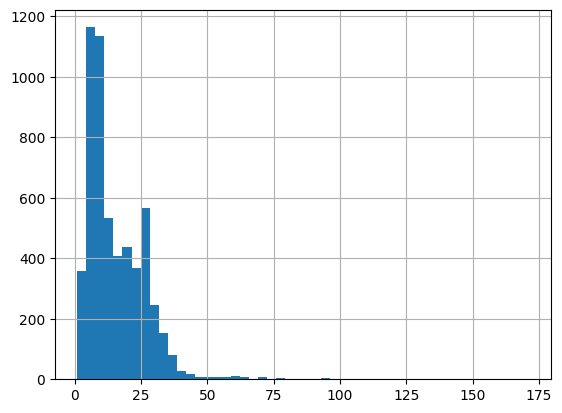

In [8]:
#understanin the distribution of length of sentences in the text data
seq_len = [len(i.split()) for i in sms_df['text']]
seq_len = pd.Series(seq_len)
seq_len.hist(bins = 50)

<Axes: >

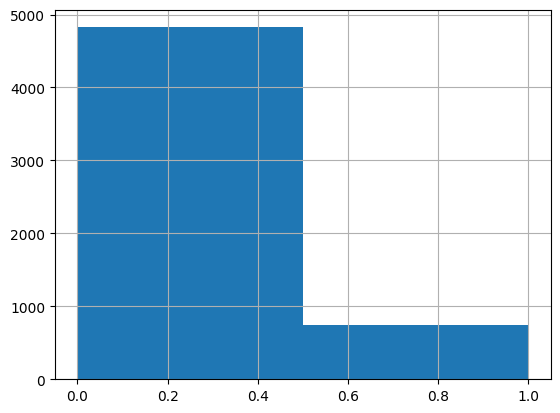

In [32]:
#Looking for imbalance in the data
sms_df.label.hist(bins=2)


In [9]:
#importing BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

#Loading the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [10]:
# sample data
sample_text = ["newton hated apples.", "a quick brown fox jumped out of einstien's equation"]

# encode sample_text
sent_id = tokenizer.batch_encode_plus(sample_text, padding=True)

# output
print(sent_id)

{'input_ids': [[101, 8446, 6283, 18108, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1037, 4248, 2829, 4419, 5598, 2041, 1997, 16417, 16643, 2368, 1005, 1055, 8522, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [11]:
sent_id.keys()
#input_id the ids of the tokens in the vocabulary
#token_type_ids whether a token belongs a certain sentence
#attention mask differentiate between actual tokens and padding
#Note 101 and 102 are special tokens representing start and end of an input text

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [12]:
print(f'Max length of a sentence in the given dataset : {seq_len.max()} \nMin length : {seq_len.min()}')
padding_length = int((seq_len.max() + seq_len.min())/2)
print(f"\nThe Padding length for the tokenizer could be about: {padding_length}")

Max length of a sentence in the given dataset : 171 
Min length : 1

The Padding length for the tokenizer could be about: 86


In [13]:
#tokenize and encode sequences
#Training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = padding_length,
    padding='max_length',
    truncation=True
)

#validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = padding_length,
    padding='max_length',
    truncation=True
)

#test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = padding_length,
    padding='max_length',
    truncation=True
)

In [14]:
#converting lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [15]:
batch_size = 32

#wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

#sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
#dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
#wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)
#sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)
#dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Model Architecture

In [16]:
# freeze all the parameters (preventing BERT from learning/Transfer Learning) while the relevant parts of the model are trained
for param in bert.parameters():
    param.requires_grad = False

In [138]:
class BERT_SpamClassifier(nn.Module):

    def __init__(self, bert):
      super(BERT_SpamClassifier, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)
      self.relu =  nn.ReLU()
      self.fc1 = nn.Linear(768,512) #first param is the number of units in the nn #second is the number of outputs
      self.fc2 = nn.Linear(512,2)
      self.softmax = nn.LogSoftmax(dim=1)
    #define the forward pass
    def forward(self, sent_id, mask):
      #pass the inputs to the model
      bert_output = self.bert(sent_id, attention_mask=mask)
      _, cls_hs = bert_output
      x = self.fc1(bert_output[cls_hs])
      x = self.relu(x)
      x = self.dropout(x)
      # output layer
      x = self.fc2(x)
      # apply softmax activation
      x = self.softmax(x)
      return x

In [139]:
# pass the pre-trained BERT to our define architecture
spamClassifier = BERT_SpamClassifier(bert)
# push the spamClassifier to GPU
spamClassifier = spamClassifier.to(device)

In [140]:
# define the optimizer
optimizer = AdamW(spamClassifier.parameters(),lr = 1e-5)

In [141]:
#Caterring to the Class imbalance in the dataset observed earlier
#computing the class weights will help cater to the imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
print("Class Weights:",class_weights)

Class Weights: [0.57748121 3.72658863]


In [142]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)
weights = weights.to(device)
cross_entropy  = nn.NLLLoss(weight=weights)

epochs = 10

In [146]:
# function to train the spamClassifier
def train():
  spamClassifier.train()
  total_loss, total_accuracy = 0, 0
  # empty list to save spamClassifier predictions
  total_preds=[]
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    # push the batch to gpu
    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch
    # clear previously calculated gradients
    spamClassifier.zero_grad()
    # get spamClassifier predictions for the current batch
    preds = spamClassifier(sent_id, mask)
    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)
    # add on to the total loss
    total_loss = total_loss + loss.item()
    # backward pass to calculate the gradients
    loss.backward()
    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(spamClassifier.parameters(), 1.0)
    # update parameters
    optimizer.step()
    # spamClassifier predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()
    # append the spamClassifier predictions
    total_preds.append(preds)
  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [147]:
# function for evaluating the spamClassifier
def evaluate():

  print("\nEvaluating...")
  # deactivate dropout layers
  spamClassifier.eval()
  total_loss, total_accuracy = 0, 0
  # empty list to save the spamClassifier predictions
  total_preds = []
  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
    # push the batch to gpu
    batch = [t.to(device) for t in batch]
    sent_id, mask, labels = batch
    # deactivate autograd
    with torch.no_grad():
      # spamClassifier predictions
      preds = spamClassifier(sent_id, mask)
      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  return avg_loss, total_preds

In [148]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    #train spamClassifier
    train_loss, _ = train()
    #evaluate spamClassifier
    valid_loss, _ = evaluate()
    #save the best spamClassifier
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(spamClassifier.state_dict(), 'saved_weights.pt')
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    140.
  Batch   100  of    140.

Evaluating...

Training Loss: 0.613
Validation Loss: 0.576

 Epoch 2 / 10
  Batch    50  of    140.
  Batch   100  of    140.

Evaluating...

Training Loss: 0.560
Validation Loss: 0.522

 Epoch 3 / 10
  Batch    50  of    140.
  Batch   100  of    140.

Evaluating...

Training Loss: 0.519
Validation Loss: 0.472

 Epoch 4 / 10
  Batch    50  of    140.
  Batch   100  of    140.

Evaluating...

Training Loss: 0.479
Validation Loss: 0.435

 Epoch 5 / 10
  Batch    50  of    140.
  Batch   100  of    140.

Evaluating...

Training Loss: 0.441
Validation Loss: 0.400

 Epoch 6 / 10
  Batch    50  of    140.
  Batch   100  of    140.

Evaluating...

Training Loss: 0.414
Validation Loss: 0.367

 Epoch 7 / 10
  Batch    50  of    140.
  Batch   100  of    140.

Evaluating...

Training Loss: 0.391
Validation Loss: 0.342

 Epoch 8 / 10
  Batch    50  of    140.
  Batch   100  of    140.

Evaluating...

Training Loss: 0.361
Validat

In [150]:
#load weights of best model
path = 'saved_weights.pt'
spamClassifier.load_state_dict(torch.load(path))

<All keys matched successfully>

In [151]:
# get predictions for test data
with torch.no_grad():
  preds = spamClassifier(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [152]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.98      0.89      0.93       483
           1       0.55      0.88      0.67        75

    accuracy                           0.89       558
   macro avg       0.76      0.88      0.80       558
weighted avg       0.92      0.89      0.90       558



In [165]:
conf_mat = confusion_matrix(test_y, preds)
print(conf_mat)

[[428  55]
 [  9  66]]


<Axes: >

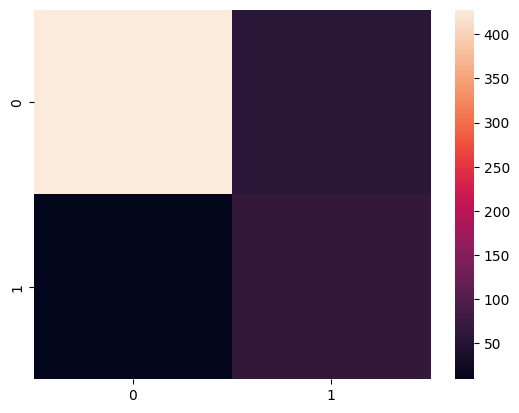

In [166]:
sns.heatmap(conf_mat)